In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

In [4]:
import feather

In [5]:
PATH = "data/bulldozers/"

df_raw = feather.read_dataframe('tmp/bulldozer-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [6]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [39]:
# df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, 
#                              na_dict=nas)
# X_train, _ = split_vals(df_trn, 20000)
# y_train, _ = split_vals(y_trn, 20000)

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                        max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20594677237775036, 0.24925680517890744, 0.9113569264354655, 0.8890462404589364, 0.8943054370347738]


In [10]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.73 s, sys: 9.3 ms, total: 1.74 s
Wall time: 1.75 s


(9.285850591650139, 0.3485443586297543)

In [12]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 69.1 ms, sys: 67 ms, total: 136 ms
Wall time: 644 ms


(9.285850591650139, 0.3485443586297543)

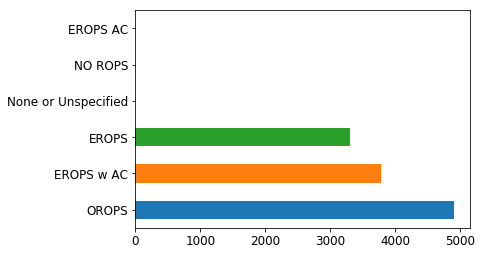

In [13]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [15]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.842278,0.283734
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.577494,0.274167
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685842,0.221953


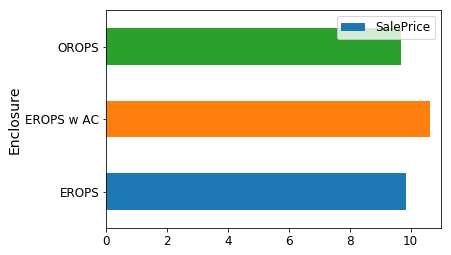

In [16]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

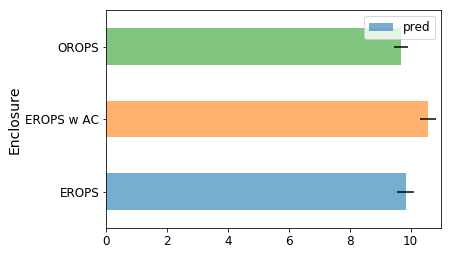

In [17]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', 
              alpha=0.6, xlim=(0,11));

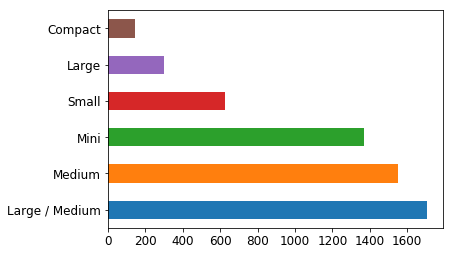

In [18]:
raw_valid.ProductSize.value_counts().plot.barh();

In [19]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.874828,0.354199
Large,10.470589,10.386880,0.368436
Large / Medium,10.691871,10.649694,0.301881
Medium,10.681511,10.615611,0.299911
Mini,9.535147,9.572005,0.271954
Small,10.324448,10.320552,0.303887


In [20]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035869
Large             0.035471
Small             0.029445
Mini              0.028411
Large / Medium    0.028346
Medium            0.028252
dtype: float64

In [27]:
# Feature Importance

In [21]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.170922
13,ProductSize,0.098843
37,Coupler_System,0.085608
14,fiProductClassDesc,0.081948
39,Hydraulics_Flow,0.068139
2,ModelID,0.054191
63,saleElapsed,0.050890
10,fiSecondaryDesc,0.045295
19,Enclosure,0.043408
8,fiModelDesc,0.033567


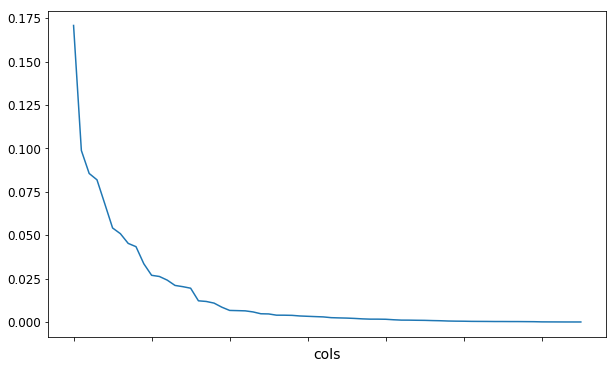

In [22]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

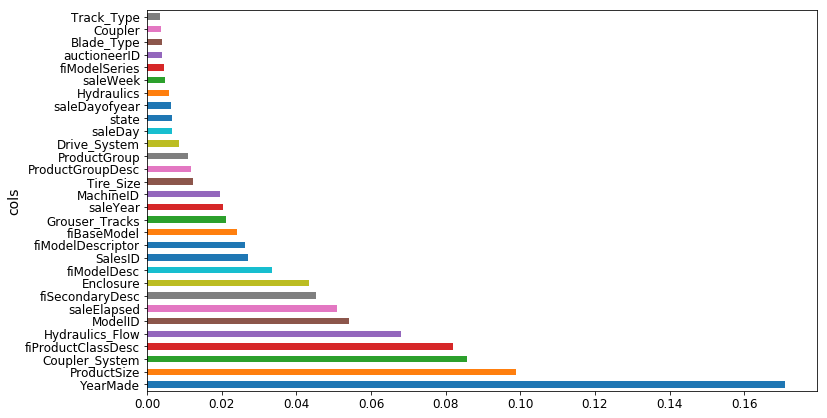

In [23]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [24]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [35]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [36]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20692824795629025, 0.24591522846684388, 0.9105100248771827, 0.8920012270750365, 0.8941560859371103]


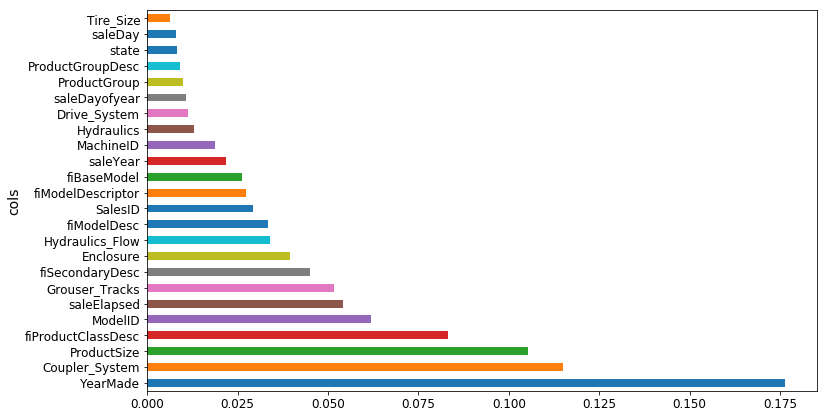

In [37]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [27]:
# One Hot Encoding

In [29]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7) 
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
       max_features=0.6, n_jobs=-1, oob_score=True) 
m.fit(X_train, y_train) 
print_score(m)

[0.2076426549016637, 0.2546127031054009, 0.9098910410363307, 0.8842267808671227, 0.8921315907684548]


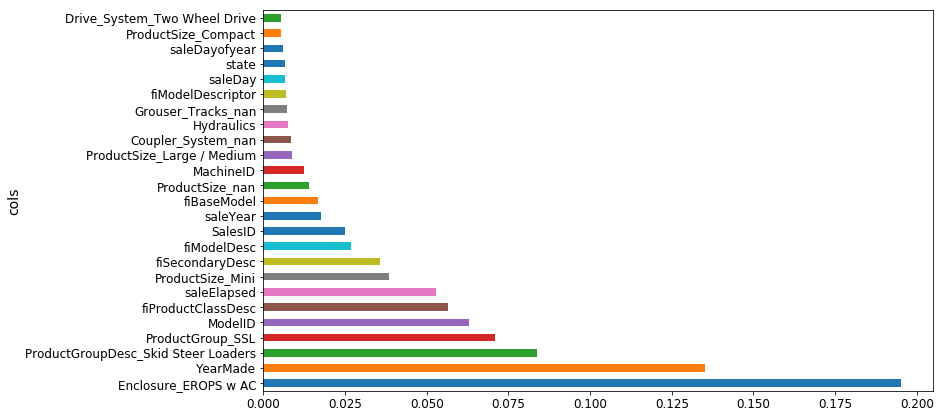

In [31]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

In [32]:
# Removing Redundant Feature

In [33]:
from scipy.cluster import hierarchy as hc

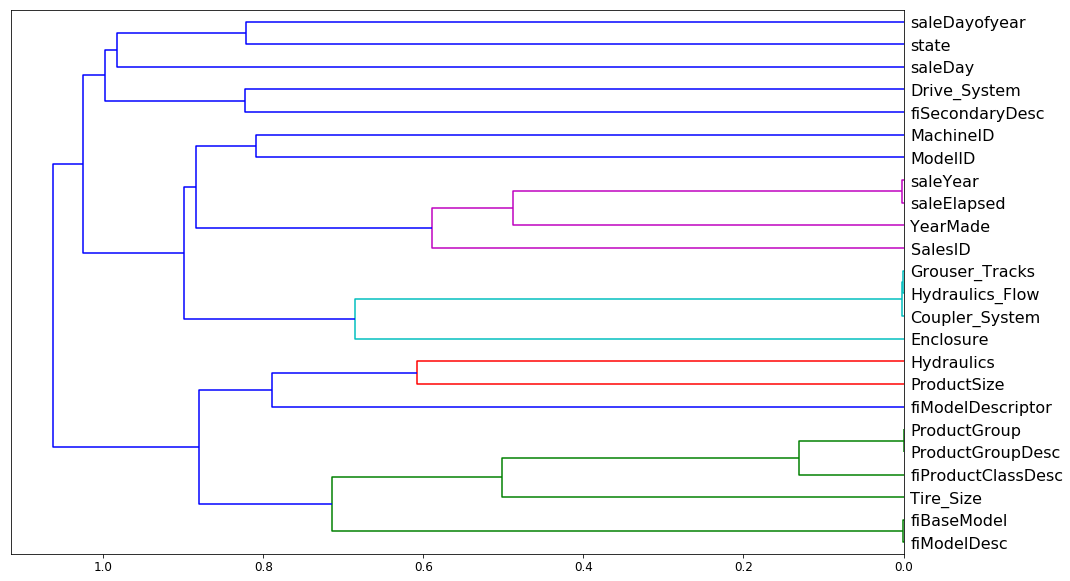

In [38]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

In [39]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, 
           max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [40]:
get_oob(df_keep)

0.8899633080163657

In [41]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 
          'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8886430699545835
saleElapsed 0.8869790369198893
fiModelDesc 0.8893164269588791
fiBaseModel 0.8883789940950032
Grouser_Tracks 0.8902904322406624
Coupler_System 0.8899159333198742


In [42]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8886324218738835

In [43]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [44]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [45]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [46]:
reset_rf_samples()

In [47]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12585335364528688, 0.22788043554445525, 0.9668972242732791, 0.9072610753644629, 0.9083474381039368]


In [ ]:
# Partial Dependencies

In [48]:
from pdpbox import pdp
from plotnine import *

In [49]:
set_rf_samples(50000)

In [50]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
       max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

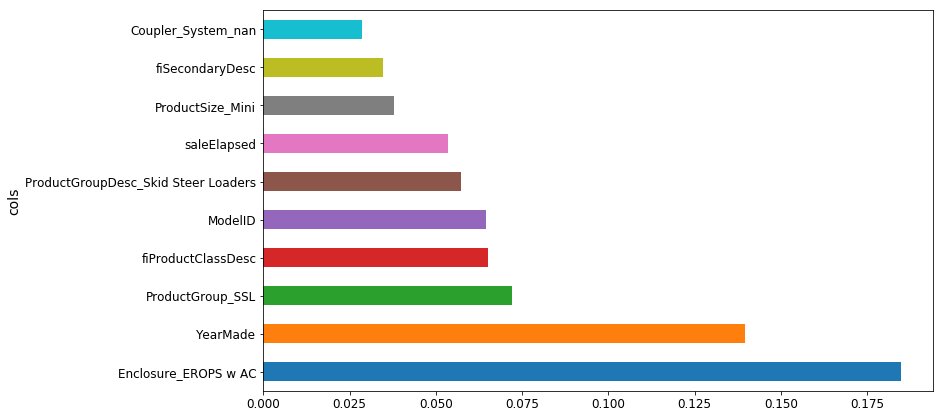

In [52]:
plot_fi(rf_feat_importance(m, df_trn2)[:10])

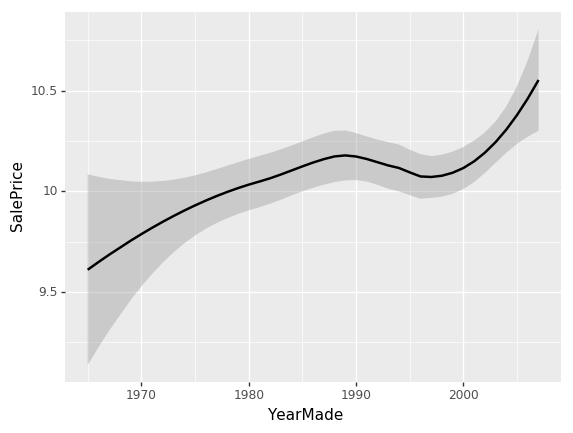

<ggplot: (289698978)>

In [55]:
x_all = get_sample(df_raw[df_raw.YearMade > 1930], 500)

ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')

In [56]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c30af4ac8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c30b20208>})

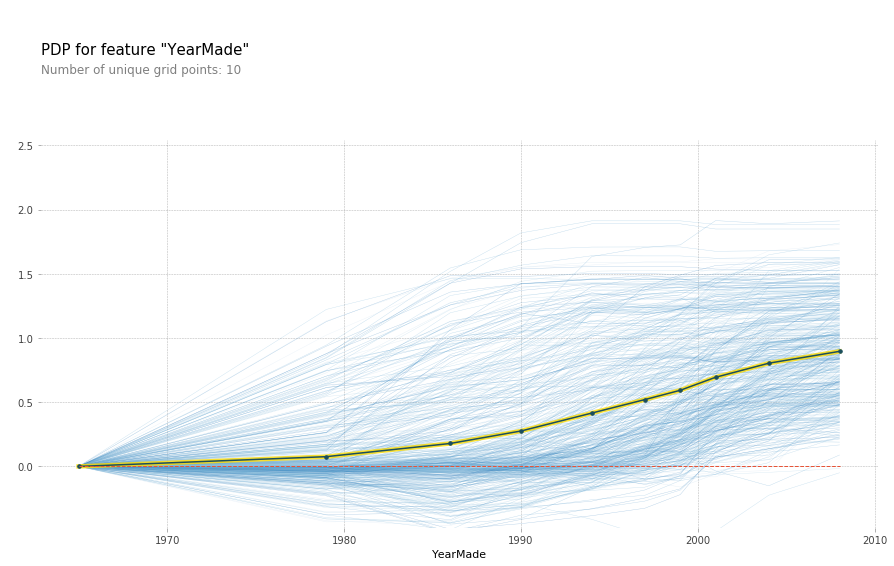

In [60]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, 
                        n_cluster_centers=clusters)
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c31043e10>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c3141dcc0>})

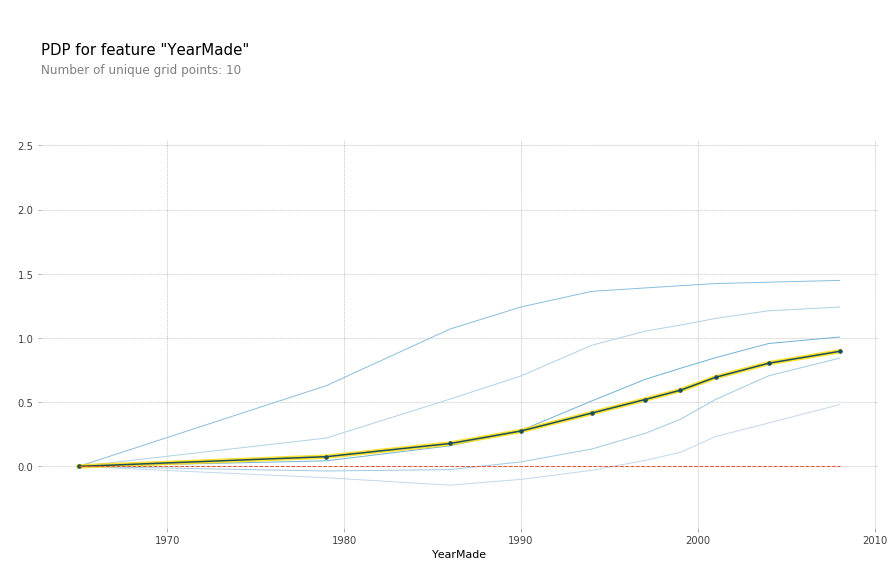

In [61]:
plot_pdp('YearMade', clusters=5) 

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

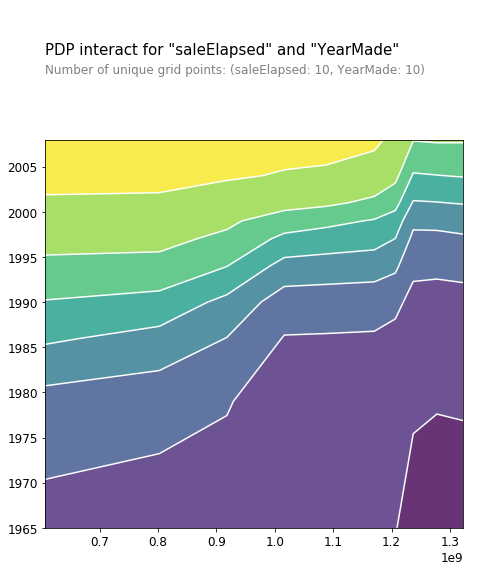

In [64]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c32644128>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c3109a048>})

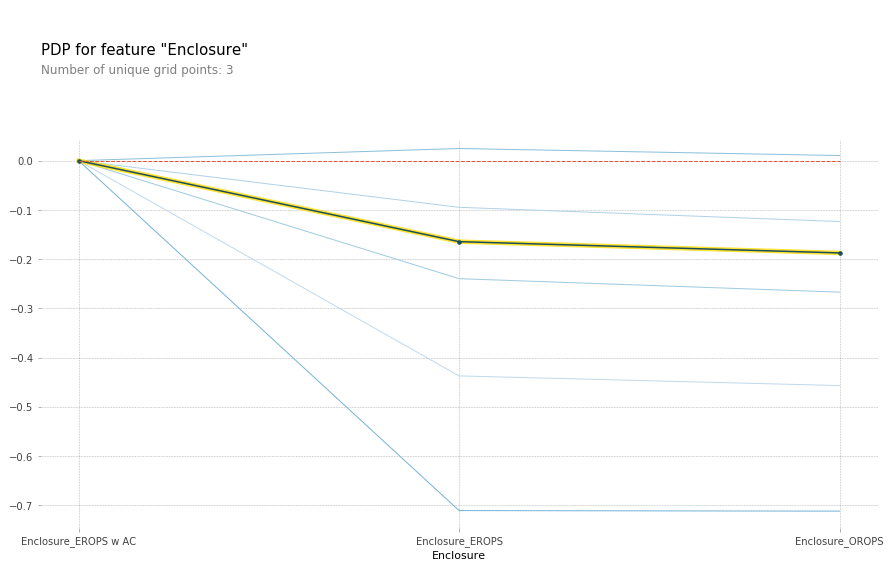

In [65]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

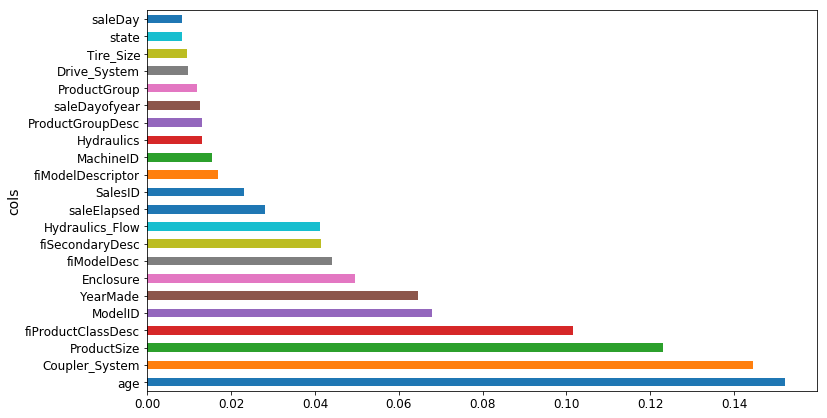

In [66]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                          max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

In [67]:
# Tree Interpreter

In [69]:
from treeinterpreter import treeinterpreter as ti

In [71]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [72]:
row = X_valid.values[None,0]; row

array([[      1999,          5,          0,         17,          0,        665, 1284595200,          0,
                 1,       3232,    4364751,          0,    2300944,          0,          4,          4,
                 0,         16,         35,        259,         12,         11]])

In [73]:
prediction, bias, contributions = ti.predict(m, row)

In [74]:
prediction[0], bias[0]

(9.29581775544402, 10.105134561887104)